In [3]:
import os
from pathlib import Path
import time
from datetime import timedelta
from tqdm import tqdm
import shutil
import numpy as np
import pickle
def save2pickle(file_name, obj):
    with open(file_name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadPickle(file_name):
    with open(file_name, 'rb') as handle:
        return pickle.load(handle)

import lineTool
def linemsg(pushMsg):
    token = 'Sv0neOgZSZVmh7YFm2SGvnjpanXFa4OoIJ8ISmJvnlO'
    # Sv0neOgZSZVmh7YFm2SGvnjpanXFa4OoIJ8ISmJvnlO
    lineTool.lineNotify(token, pushMsg)

import sys
sys.path.append("/home/privacy/")
import icd9_obj 
icd9obj = icd9_obj.ICD9_obj()

import matplotlib.pyplot as plt

In [3]:
# !nvidia-smi

In [4]:
import torch
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = "cuda" if torch.cuda.is_available() else "CPU"
print(device)

# Load model directly
from transformers import AutoTokenizer

model_dir = os.path.join(r'/home/lang_model/',  'M7B-token2')

MAX_LEN = 8192
tokenizer = AutoTokenizer.from_pretrained(
            model_dir,
            model_max_length=MAX_LEN,
            padding_side="left",
            add_eos_token=False)
tokenizer.pad_token = tokenizer.eos_token


cuda


In [5]:
def getSeqLen(txt):
    # num of words including symbol
    inputs = tokenizer(txt, return_tensors="pt").to(device)
    len = inputs.input_ids.shape[1]
    return len

In [4]:
result_dir = r'./util_eval/length'
Path(result_dir).mkdir(parents=True, exist_ok=True)

root = r'/home/privacy/data/MIMIC3'

data_type_ls = ['deid', 'reid']
data_type = 'reid' #; src_data_dir = os.path.join( r'/home/privacy/data/MIMICIII_ori_nosp')

prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')

generation_ls = ['one_shot_src', 'keyword', 'one_shot_src']
generation_type = 'one_shot_test'

model_ls = ['Mistral7b', 'gpt-35-turbo-a0301',  'gpt-4-0613',]
model_type = model_ls[1]

title = f'{data_type} {generation_type} {model_type}'
print(title)


reid one_shot_test gpt-35-turbo-a0301


In [5]:
ipynb_fn = '.ipynb_checkpoints'
tot = 0
for i in range(len(icd9obj.ICD9_ABBR_LS)):
    icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
    output_dir = os.path.join(prompt_dir, generation_type, model_type, icd9_abbr)
    if os.path.exists(output_dir): 
        if os.path.exists(os.path.join(output_dir, ipynb_fn)): shutil.rmtree(os.path.join(output_dir, ipynb_fn))
            
        print(f'{len(os.listdir(output_dir))} / {icd9obj.getICD9_NUM(icd9_abbr)} -- {icd9_abbr}')
        tot += len(os.listdir(output_dir))
print(tot)
# print(output_dir)

1063 / 1067 -- ARF
999 / 1002 -- CHF
1081 / 1083 -- AKF
3447 / 3452 -- HPN
989 / 993 -- CAS
410 / 410 -- DM2
1009 / 1010 -- AF
798 / 800 -- UTI
9796


#### single

In [8]:
key = f'{data_type} {generation_type} {model_type}'
len_pickle_fp = os.path.join(result_dir, f"{key.replace(' ', '_')}.pickle")
print(key, len_pickle_fp )
icd9_len_dict = {}
for i in range(len(icd9obj.ICD9_ABBR_LS)):
    icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
    output_dir = os.path.join(prompt_dir, generation_type, model_type, icd9_abbr)
    if os.path.exists(output_dir): 
        ls = []
        for fn in tqdm(os.listdir(output_dir)):
            if 'ipynb' in fn:continue
            with open(os.path.join(output_dir, fn), 'r') as fr:
                ls.append(getSeqLen(fr.read()))
        ls = np.array(ls)
        icd9_len_dict[icd9_abbr] = ls
        # print([int(i) for i in [ls.max(), ls.mean(), ls.std(), ls.min()]])
save2pickle(len_pickle_fp, icd9_len_dict)

reid one_shot_test gpt-35-turbo-a0301 ./util_eval/length/reid_one_shot_test_gpt-35-turbo-a0301.pickle


100%|████████████████████████████████████████████████████████████████████████████| 790/790 [00:00<00:00, 1067.10it/s]


#### Combined

In [18]:
for data_type in data_type_ls:
    prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')
    for generation_type in generation_ls:
        # showmsg(f'***** {data_type.upper()} -- {generation_type}')
        for model_type in model_ls:
            key = f'{data_type} {generation_type} {model_type}'
            print(key)
            len_pickle_fp = os.path.join(result_dir, f"{key.replace(' ', '_')}.pickle")
            # if os.path.exists(len_pickle_fp): continue
            # print(len_pickle_fp)
            # continue
            icd9_len_dict = {}
            for i in range(len(icd9obj.ICD9_ABBR_LS)):
                icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
                output_dir = os.path.join(prompt_dir, generation_type, model_type, icd9_abbr)
                if os.path.exists(output_dir): 
                    ls = []
                    for fn in tqdm(os.listdir(output_dir)):
                        if 'ipynb' in fn:continue
                        with open(os.path.join(output_dir, fn), 'r') as fr:
                            ls.append(getSeqLen(fr.read()))
                    ls = np.array(ls)
                    icd9_len_dict[icd9_abbr] = ls
                    # print([int(i) for i in [ls.max(), ls.mean(), ls.std(), ls.min()]])
            save2pickle(len_pickle_fp, icd9_len_dict)

deid one_shot_src Mistral7b


100%|█████████████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 285.93it/s]


reid one_shot_src Mistral7b


100%|█████████████████████████████████████████████████████████████████████████████| 800/800 [00:01<00:00, 489.65it/s]


# Check Results

In [18]:
root = r'/home/privacy/data/MIMIC3'

data_type_ls = ['deid', 'reid']
data_type = 'reid' #; src_data_dir = os.path.join( r'/home/privacy/data/MIMICIII_ori_nosp')

prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')

generation_ls = ['one_shot', 'keyword', 'one_shot_src']
generation_type = 'one_shot_src'

model_ls = [ 'gpt-35-turbo-a0301',  'gpt-4-0613', 'Mistral7b']
model_type = model_ls[1]

title = f'{data_type} {generation_type} {model_type}'

len_pickle_fp = os.path.join(result_dir, f"{title.replace(' ', '_')}.pickle")

print(title, len_pickle_fp)

reid one_shot_src gpt-4-0613 ./util_eval/length/reid_one_shot_src_gpt-4-0613.pickle


In [8]:
len_dict = loadPickle(len_pickle_fp)
ls = [s for k , v in len_dict.items() for s in v]
ls = np.array(ls)
print(len(ls), [int(i) for i in [ls.max(), ls.mean(), ls.std(), ls.min()]])

9815 [3063, 1076, 702, 1]


In [19]:
data_ls = []
label_ls = []

# for data_type in data_type_ls:
data_type = 'reid'
prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')
for generation_type in  generation_ls:# ['keyword', 'one_shot', 'one_shot_src']:
    for model_type in model_ls: #['gpt-35-turbo-a0301']:#, 'gpt-4-0613' ]: 
        
        key = f'{data_type}_{generation_type}_{model_type}'
        len_pickle_fp = os.path.join(result_dir, f"{key}.pickle")
        len_dict = loadPickle(len_pickle_fp)
        
        ls = np.array([s for k , v in len_dict.items() for s in v])
        # print(len(ls), [int(i) for i in [ls.max(), ls.mean(), ls.std(), ls.min()]])
        data_ls.append(ls)
        # # label_ls.append(f'{model_type}')
        # # label_ls.append(f'{model_type}_{icd9_abbr}')
        label_ls.append(generation_type)
        
        # for icd9_abbr, ls  in len_dict.items():
        #     data_ls.append(np.array(ls))
        #     # label_ls.append(f'{generation_type}_{icd9_abbr}')
        #     label_ls.append(f'{generation_type}')

In [44]:
data_ls = []
label_ls = []
label2nd_ls = []

for model_type, model_abbr in list(zip(['gpt-35-turbo-a0301', 'gpt-4-0613', 'Mistral7b' ], ['GPT3.5', 'GPT4', 'Mistral7B'])): 
    for data_type in ['reid', 'deid']:
        # data_type = 'reid'
        prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')
        for generation_type, gene_abbr in  list(zip(['keyword', 'one_shot', 'one_shot_src'], ['Keyword', 'oneshot+Normalized', 'oneshot'])):
        # for generation_type in  ['one_shot_test', 'one_shot_src']:
            # for model_type in ['gpt-4-0613']: 
        
            
            key = f'{data_type}_{generation_type}_{model_type}'
            len_pickle_fp = os.path.join(result_dir, f"{key}.pickle")
            len_dict = loadPickle(len_pickle_fp)
            
            ls = np.array([s for k , v in len_dict.items() for s in v])
            print(len(ls), key) #[int(i) for i in [ls.max(), ls.mean(), ls.std(), ls.min()]])
            data_ls.append(ls)
            # # label_ls.append(f'{model_type}')
            # # label_ls.append(f'{model_type}_{icd9_abbr}')
            label_ls.append(model_abbr)
    
            label2nd_ls.append(gene_abbr)
    print('='*100)
        # for icd9_abbr, ls  in len_dict.items():
        #     data_ls.append(np.array(ls))
        #     # label_ls.append(f'{generation_type}_{icd9_abbr}')
        #     label_ls.append(f'{generation_type}')

9812 reid_keyword_gpt-35-turbo-a0301
9804 reid_one_shot_gpt-35-turbo-a0301
9815 reid_one_shot_src_gpt-35-turbo-a0301
9815 deid_keyword_gpt-35-turbo-a0301
9804 deid_one_shot_gpt-35-turbo-a0301
9812 deid_one_shot_src_gpt-35-turbo-a0301
9810 reid_keyword_gpt-4-0613
9806 reid_one_shot_gpt-4-0613
9815 reid_one_shot_src_gpt-4-0613
9809 deid_keyword_gpt-4-0613
9809 deid_one_shot_gpt-4-0613
9816 deid_one_shot_src_gpt-4-0613
9817 reid_keyword_Mistral7b
9817 reid_one_shot_Mistral7b
9817 reid_one_shot_src_Mistral7b
9817 deid_keyword_Mistral7b
9817 deid_one_shot_Mistral7b
9817 deid_one_shot_src_Mistral7b


In [37]:
len(data_ls), len(label_ls), len(label2nd_ls)

(18, 18, 18)

In [24]:
label2nd_ls = [
'', 'Keyword', '',
'', 'Normalized One-shot', '',
'', 'One-shot', '',]

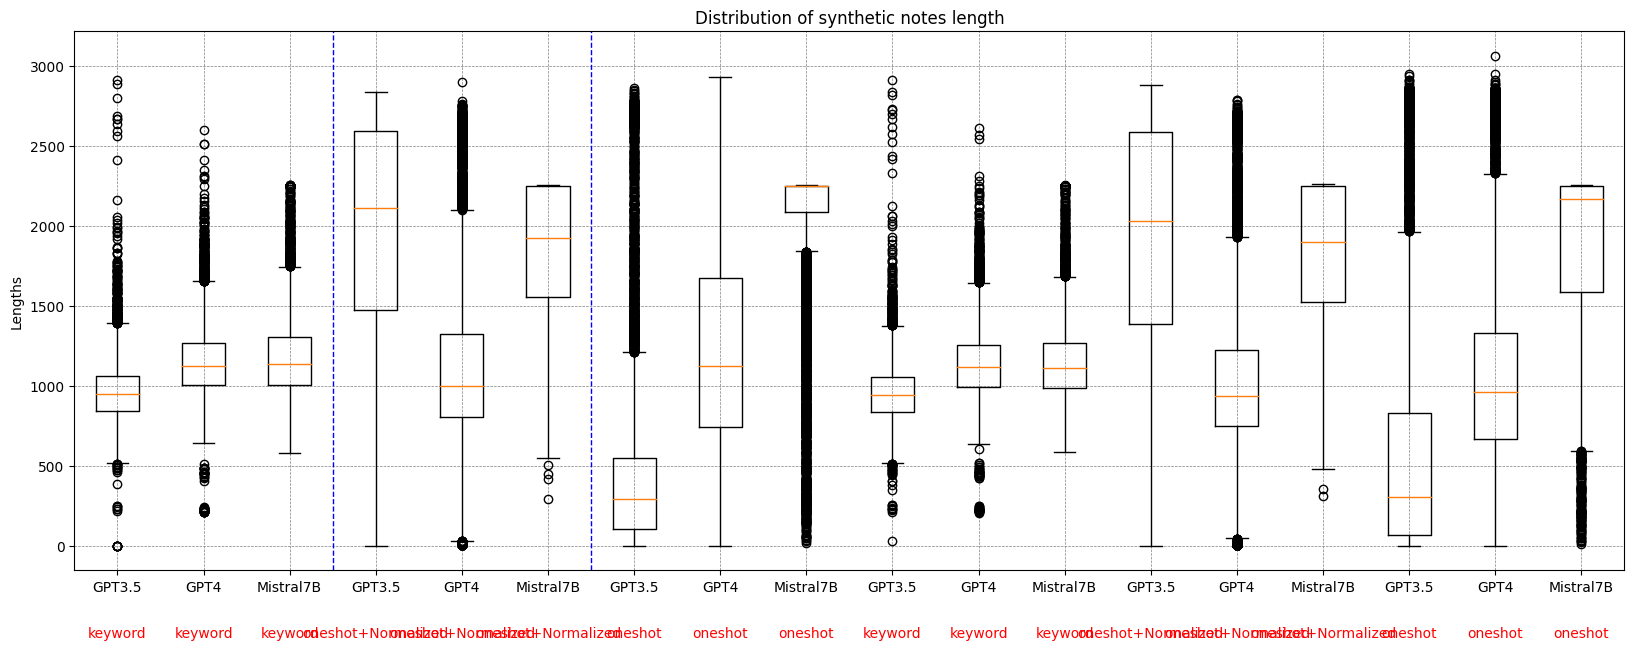

In [38]:
# plt.figure(figsize=(20, 6))
# plt.boxplot(data_ls, labels=label_ls)
# plt.title('Distribution of synthetic notes length')
# plt.ylabel('Size')
# plt.show()


fig, ax = plt.subplots(figsize=(20, 7))
ax.boxplot(data_ls)

ax.set_xticks(list(range(1, len(label_ls)+1)))
ax.set_xticklabels(label_ls)

data1 = [np.min(k) for k in data_ls]

# Adding secondary annotations
secondary_labels = label2nd_ls
for i, label in enumerate(secondary_labels):
    ax.text(i+1, min(np.min(data1), np.min(data1)) - 500, label, ha='center', va='top', fontsize=10, color='red')

ax.axvline(3.5, color='blue', linestyle='--', linewidth=1)  # Adjust x position as needed
ax.axvline(6.5, color='blue', linestyle='--', linewidth=1)  # Adjust x position as needed
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.title('Distribution of synthetic notes length')
plt.ylabel('Lengths')


fig.savefig('Distribution_synthetic_notes_length.png', dpi=1200, bbox_inches='tight', transparent=True)

plt.show()

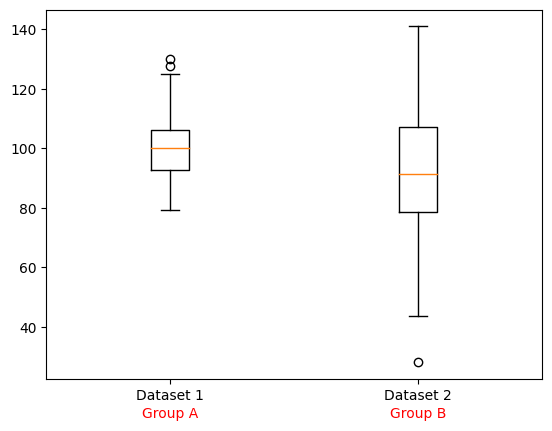

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data1 = np.random.normal(100, 10, 200)
data2 = np.random.normal(90, 20, 200)
data = [data1, data2]

# Creating the boxplot
fig, ax = plt.subplots()
ax.boxplot(data)

# Primary x-axis labels
primary_labels = ['Dataset 1', 'Dataset 2']
ax.set_xticks([1, 2])
ax.set_xticklabels(primary_labels)

# Adding secondary annotations
secondary_labels = ['Group A', 'Group B']
for i, label in enumerate(secondary_labels):
    ax.text(i+1, min(np.min(data1), np.min(data2)) - 15, label, ha='center', va='top', fontsize=10, color='red')

# Show plot
plt.show()


In [93]:
result_dir = r'./util_eval/rouge/'
data_ls = []
label_ls = []
label2nd_ls = []

# for data_type in data_type_ls:
data_type = 'reid'
prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')
# for generation_type, gene_abbr in  list(zip(['keyword', 'one_shot', ], ['keyword', 'oneshot+Normalized',])):
for generation_type, gene_abbr in  list(zip(['keyword', 'one_shot', 'one_shot_src'], ['keyword', 'oneshot+Normalized', 'oneshot'])):
    for model_type, model_abbr in list(zip(['gpt-35-turbo-a0301', 'gpt-4-0613', 'Mistral7b' ], ['GPT35', 'GPT4', 'Mistral7B'])): 
        
        key = f'{data_type}_{generation_type}_{model_type}'
        rogue_pickle_fp = os.path.join(result_dir, f"{key}.pickle")
        rouge_pair_dict = loadPickle(rogue_pickle_fp)
        for r_name in ['rouge1', 'rouge2', 'rouge3', 'rougeL']:
            # print(r_name)
            df = rouge_pair_dict[r_name]
            row_str = ''
            for rouge_col in ['precision', 'recall', 'fmeasure']:
                row_str += f'{eval(f"df.{rouge_col}.mean()"):.2f}, {eval(f"df.{rouge_col}.std()"):.2f}, '
            print(f'{key}, {r_name}, {row_str}')
        

reid_keyword_gpt-35-turbo-a0301, rouge1, 0.76, 0.10, 0.27, 0.08, 0.39, 0.08, 
reid_keyword_gpt-35-turbo-a0301, rouge2, 0.28, 0.08, 0.10, 0.04, 0.14, 0.05, 
reid_keyword_gpt-35-turbo-a0301, rouge3, 0.11, 0.05, 0.04, 0.02, 0.06, 0.03, 
reid_keyword_gpt-35-turbo-a0301, rougeL, 0.42, 0.08, 0.15, 0.05, 0.22, 0.06, 
reid_keyword_gpt-4-0613, rouge1, 0.73, 0.09, 0.30, 0.08, 0.42, 0.08, 
reid_keyword_gpt-4-0613, rouge2, 0.26, 0.07, 0.11, 0.04, 0.15, 0.05, 
reid_keyword_gpt-4-0613, rouge3, 0.10, 0.05, 0.04, 0.02, 0.06, 0.03, 
reid_keyword_gpt-4-0613, rougeL, 0.41, 0.07, 0.17, 0.06, 0.24, 0.06, 
reid_keyword_Mistral7b, rouge1, 0.73, 0.09, 0.28, 0.08, 0.40, 0.08, 
reid_keyword_Mistral7b, rouge2, 0.24, 0.07, 0.09, 0.04, 0.13, 0.04, 
reid_keyword_Mistral7b, rouge3, 0.09, 0.04, 0.04, 0.02, 0.05, 0.02, 
reid_keyword_Mistral7b, rougeL, 0.32, 0.07, 0.13, 0.05, 0.18, 0.05, 
reid_one_shot_gpt-35-turbo-a0301, rouge1, 0.93, 0.07, 0.56, 0.27, 0.66, 0.26, 
reid_one_shot_gpt-35-turbo-a0301, rouge2, 0.76, 0.17,

FileNotFoundError: [Errno 2] No such file or directory: './util_eval/rouge/reid_one_shot_src_Mistral7b.pickle'

rouge1, 0.87, 0.06, 0.50, 0.17, 0.62, 0.15, 
rouge2, 0.63, 0.12, 0.37, 0.16, 0.45, 0.15, 
rouge3, 0.52, 0.13, 0.30, 0.15, 0.37, 0.15, 
rougeL, 0.74, 0.12, 0.43, 0.18, 0.53, 0.17, 


In [83]:
df.columns

Index(['precision', 'recall', 'fmeasure'], dtype='object')

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U9'), dtype('<U9')) -> None

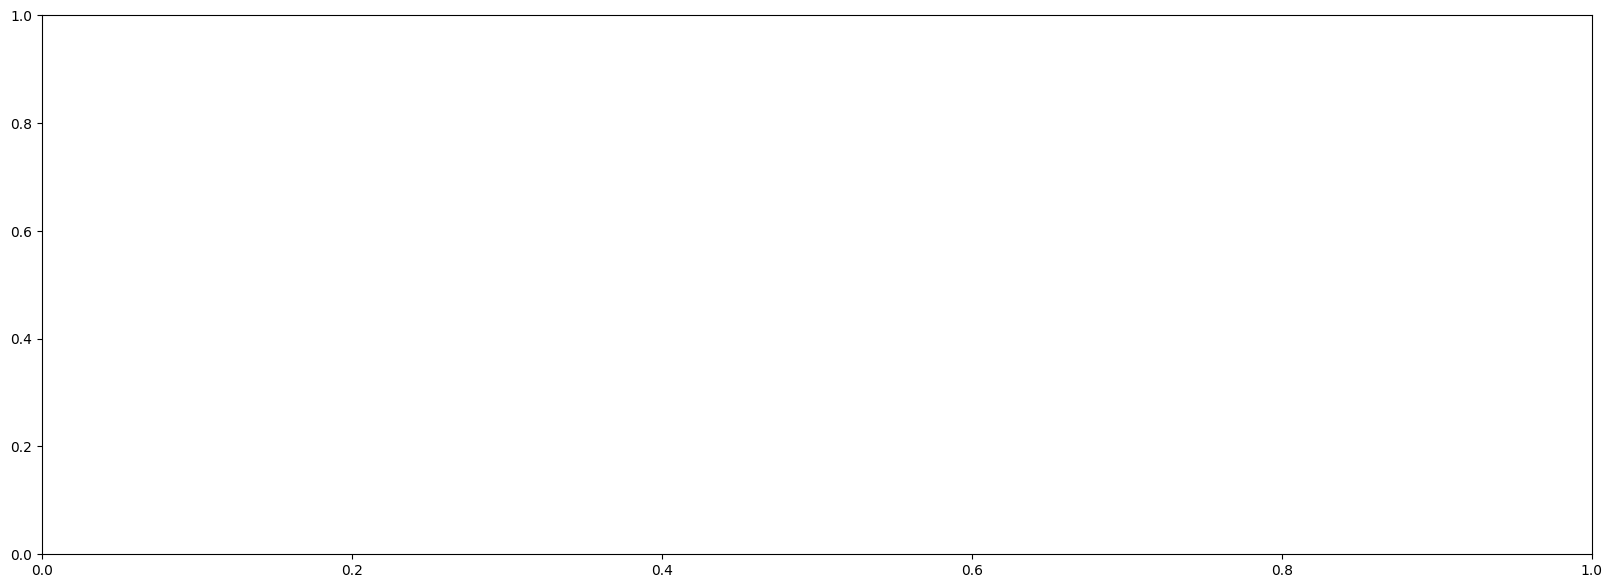

In [66]:
# plt.figure(figsize=(20, 6))
# plt.boxplot(data_ls, labels=label_ls)
# plt.title('Distribution of synthetic notes length')
# plt.ylabel('Size')
# plt.show()


fig, ax = plt.subplots(figsize=(20, 7))
ax.boxplot(data_ls)

ax.set_xticks(list(range(1, len(label_ls)+1)))
ax.set_xticklabels(label_ls)

# Adding secondary annotations
secondary_labels = label2nd_ls
for i, label in enumerate(secondary_labels):
    ax.text(i+1, min(np.min(data1), np.min(data2)) - 500, label, ha='center', va='top', fontsize=10, color='red')

ax.axvline(3.5, color='blue', linestyle='--', linewidth=1)  # Adjust x position as needed
ax.axvline(6.5, color='blue', linestyle='--', linewidth=1)  # Adjust x position as needed
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.title('Distribution of synthetic notes length')
plt.ylabel('Size')


fig.savefig('Distribution_synthetic_notes_length.png', dpi=1200, bbox_inches='tight', transparent=True)

plt.show()